In [1]:
import sys
import os


notebook_dir = os.path.dirname(os.path.realpath("__file__"))  # Path to notebooks directory
parent_dir = os.path.dirname(notebook_dir)  # Parent directory of notebooks

sys.path.append(parent_dir)

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from rc.risk_control import rc_main

from matplotlib.ticker import FormatStrFormatter
from plotting_style import *

In [3]:
PATH = './data'

DATASET = 'cnndm'
# DATASET = 'squad'

In [4]:
# read in precomputed exits and losses for CALM model
with open(f'{PATH}/calm_{DATASET}.p', 'rb') as f:
    res_dict = pickle.load(f)
lambdas, exits, losses = res_dict

# check that thresholds are sorted in descending order
assert np.array_equal(sorted(lambdas, reverse=True), lambdas)
assert round(lambdas[0], 8) == 1.

In [5]:
# compute relative losses
rel_losses = losses.copy()
for i in range(len(losses)):
    rel_losses[i] = losses[0] - losses[i]

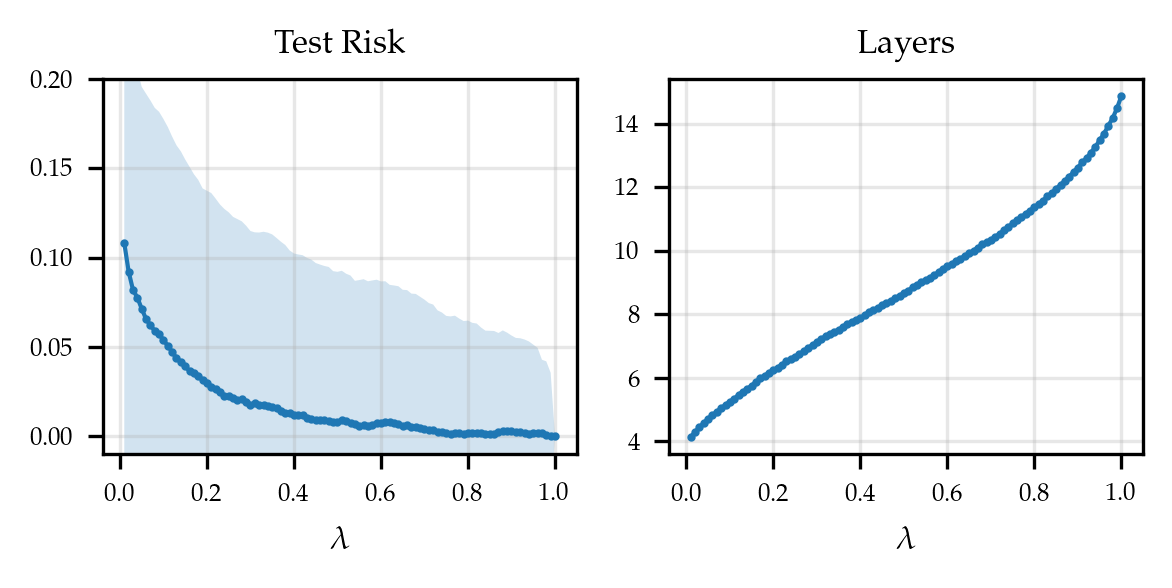

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex=True)

ax[0].plot(lambdas, rel_losses.mean(axis=1), marker='o', markersize=1)
ax[0].fill_between(lambdas, rel_losses.mean(axis=1) - rel_losses.std(axis=1), 
                   rel_losses.mean(axis=1) + rel_losses.std(axis=1), alpha=0.2)
ax[0].set_ylim(-0.01, 0.2)

ax[1].plot(lambdas, exits, marker='o', markersize=1)

ax[0].set_title('Test Risk')
ax[1].set_title('Layers')

ax[0].set_xlabel('$\lambda$')
ax[1].set_xlabel('$\lambda$')

plt.show()

In [7]:
EPSILONS = np.arange(0.01, 0.2, 0.01)
RCP_TYPES = ['crc', 'ucb-wsr', 'ltt']
DELTA = 0.1
N_TRIALS = 50
N_CAL = 100

In [8]:
test_risk, eff_gains, _ = rc_main(rel_losses, exits, eps_grid=EPSILONS, rcp_types=RCP_TYPES, delta=DELTA, n_cal=N_CAL, n_trials=N_TRIALS,)

/home/metod/Desktop/PhD/year2/LTT/RC-EENN/rc/bounds.py:78: RuntimeWarning: divide by zero encountered in log
  h1 = a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))
/home/metod/Desktop/PhD/year2/LTT/RC-EENN/rc/bounds.py:78: RuntimeWarning: invalid value encountered in double_scalars
  h1 = a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))


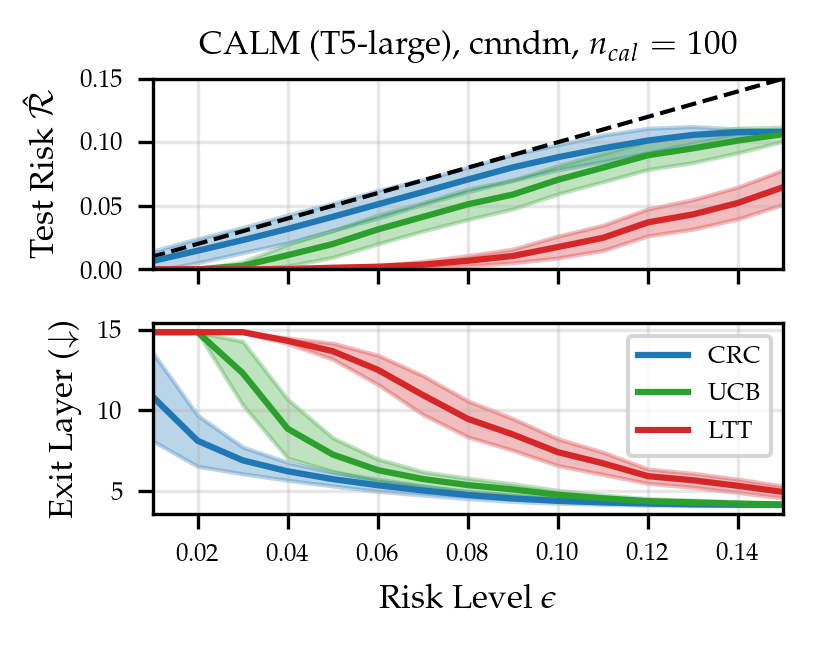

In [9]:
RCP_COLOR_MAP = {"Random": "grey", "LTT": "tab:red", "UCB": "tab:green", "CRC": "tab:blue"}
label_map = lambda s: s.split('-', 1)[0].upper()


EPS_UPPER = 0.15
fig, ax = plt.subplots(2, 1, figsize=(text_width * 0.5, text_width * 0.4), sharex=True)

ax[0].set_xlim(0.01, EPS_UPPER)
ax[0].set_ylim(0, EPS_UPPER)
ax[0].plot([0, 1], [0, 1], 'k--')


for i, rcp_type in enumerate(RCP_TYPES):
    rcp_name = label_map(rcp_type)
    ls = '--' if "[-1,1]" in rcp_type else '-' 
    test_risk_i = np.array(test_risk[rcp_type])
    eff_gains_i = np.array(eff_gains[rcp_type])

    test_risk_i_mu = test_risk_i.mean(axis=0)
    test_risk_i_std = test_risk_i.std(axis=0)

    eff_gains_i_mu = eff_gains_i.mean(axis=0)
    eff_gains_i_std = eff_gains_i.std(axis=0)


    ax[0].plot(EPSILONS, test_risk_i_mu, label=rcp_name, lw=LW, color=RCP_COLOR_MAP[rcp_name], ls=ls)
    ax[0].fill_between(EPSILONS, test_risk_i_mu - test_risk_i_std, test_risk_i_mu + test_risk_i_std, alpha=ALPHA, color=RCP_COLOR_MAP[rcp_name])

    ax[1].plot(EPSILONS, eff_gains_i_mu, label=rcp_name, lw=LW, color=RCP_COLOR_MAP[rcp_name], ls=ls)
    ax[1].fill_between(EPSILONS, eff_gains_i_mu - eff_gains_i_std, eff_gains_i_mu + eff_gains_i_std, alpha=ALPHA, color=RCP_COLOR_MAP[rcp_name])


ax[0].set_ylabel('Test Risk $\hat{\mathcal{R}}$')
ax[1].set_ylabel('Exit Layer ($\downarrow$)')
ax[1].set_xlabel('Risk Level $\epsilon$')

ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].legend(loc='upper right')

ax[0].set_title("CALM (T5-large), " + DATASET + f", $n_{{cal}}={N_CAL}$")
plt.tight_layout()
plt.show()

